Libraries

In [5]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install tensorflow
!pip install mne
!pip install scipy
!pip install librosa
!pip install gtts
!pip install matplotlib
!pip install seaborn

Configuration Class

In [6]:

class Config:
    # Data parameters
    CHANNELS = ['TP9', 'AF7', 'AF8', 'TP10']
    SAMPLING_RATE = 256  # Hz
    WINDOW_SIZE = 256    # samples
    OVERLAP = 0.5        # 50% overlap
    SEGMENT_DURATION = 1.0  # seconds
    
    # Model parameters
    CNN_FILTERS = [64, 128, 256]
    LSTM_UNITS = 128
    DENSE_UNITS = 64
    DROPOUT_RATE = 0.5
    
    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 100
    LEARNING_RATE = 0.001
    VALIDATION_SPLIT = 0.2

# Initialize configuration
config = Config()

Data Loading and Visualization

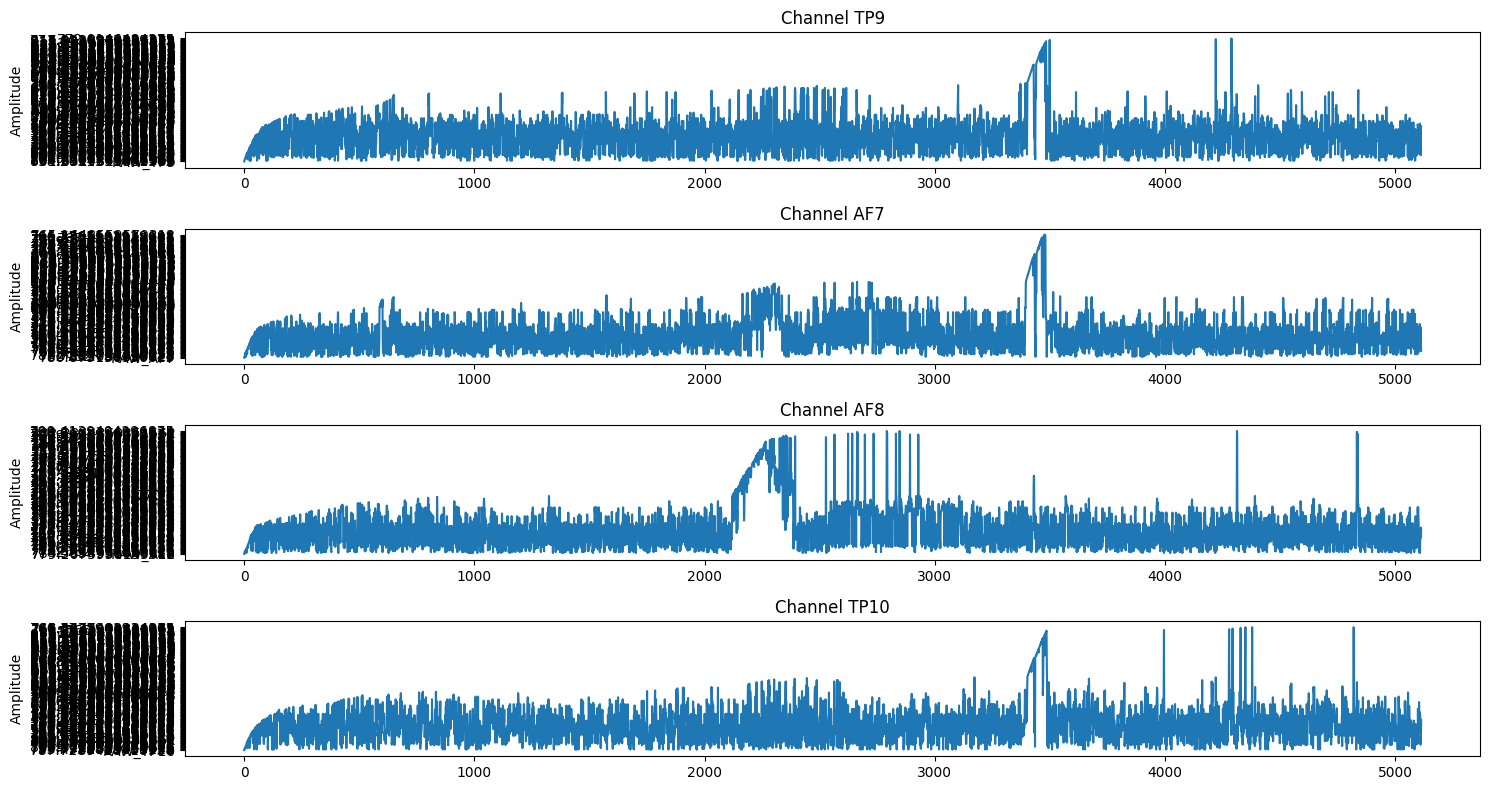

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def load_and_visualize_data(file_path):
    """Load data and create visualizations"""
    # Read CSV file
    data = pd.read_csv(file_path, header=None)
    data.columns = ['Timestamp'] + Config.CHANNELS
    
    # Plot raw EEG signals
    plt.figure(figsize=(15, 8))
    for i, channel in enumerate(Config.CHANNELS, 1):
        plt.subplot(len(Config.CHANNELS), 1, i)
        plt.plot(data[channel])
        plt.title(f'Channel {channel}')
        plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    
    return data

# Example usage:
data = load_and_visualize_data('/workspaces/EEG_to_Speech/Dataset/Train/Left.2023-01-29 19_34_59.258466.csv')

Data Preprocessing Class

In [9]:

class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
    
    def preprocess_file(self, file_path):
        """Complete preprocessing pipeline for a single file"""
        # Load data
        data = pd.read_csv(file_path, header=None)
        channel_data = data.iloc[:, 1:5].values  # TP9, AF7, AF8, TP10
        
        # Apply bandpass filter
        filtered_data = self.apply_bandpass_filter(channel_data)
        
        # Normalize
        normalized_data = self.scaler.fit_transform(filtered_data)
        
        # Segment
        segmented_data = self.segment_data(normalized_data)
        
        return segmented_data
    
    def apply_bandpass_filter(self, data):
        """Apply bandpass filter to remove artifacts"""
        nyquist = self.config.SAMPLING_RATE / 2
        b, a = signal.butter(4, [0.5/nyquist, 45/nyquist], btype='band')
        return signal.filtfilt(b, a, data, axis=0)
    
    def segment_data(self, data):
        """Segment data into windows"""
        window_size = int(self.config.SAMPLING_RATE * self.config.SEGMENT_DURATION)
        step = int(window_size * (1 - self.config.OVERLAP))
        segments = []
        
        for i in range(0, len(data) - window_size + 1, step):
            segment = data[i:i + window_size]
            segments.append(segment)
        
        return np.array(segments)

# Initialize processor
processor = DataProcessor(config)

In [12]:
# Cell 4: Data Preprocessing Class
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
    
    def preprocess_file(self, file_path):
        """Complete preprocessing pipeline for a single file"""
        # Load data
        data = pd.read_csv(file_path, header=None)
        channel_data = data.iloc[:, 1:5].values  # TP9, AF7, AF8, TP10
        
        # Apply bandpass filter
        filtered_data = self.apply_bandpass_filter(channel_data)
        
        # Remove artifacts
        cleaned_data = self.remove_artifacts(filtered_data)
        
        # Normalize
        normalized_data = self.scaler.fit_transform(cleaned_data)
        
        # Segment
        segmented_data = self

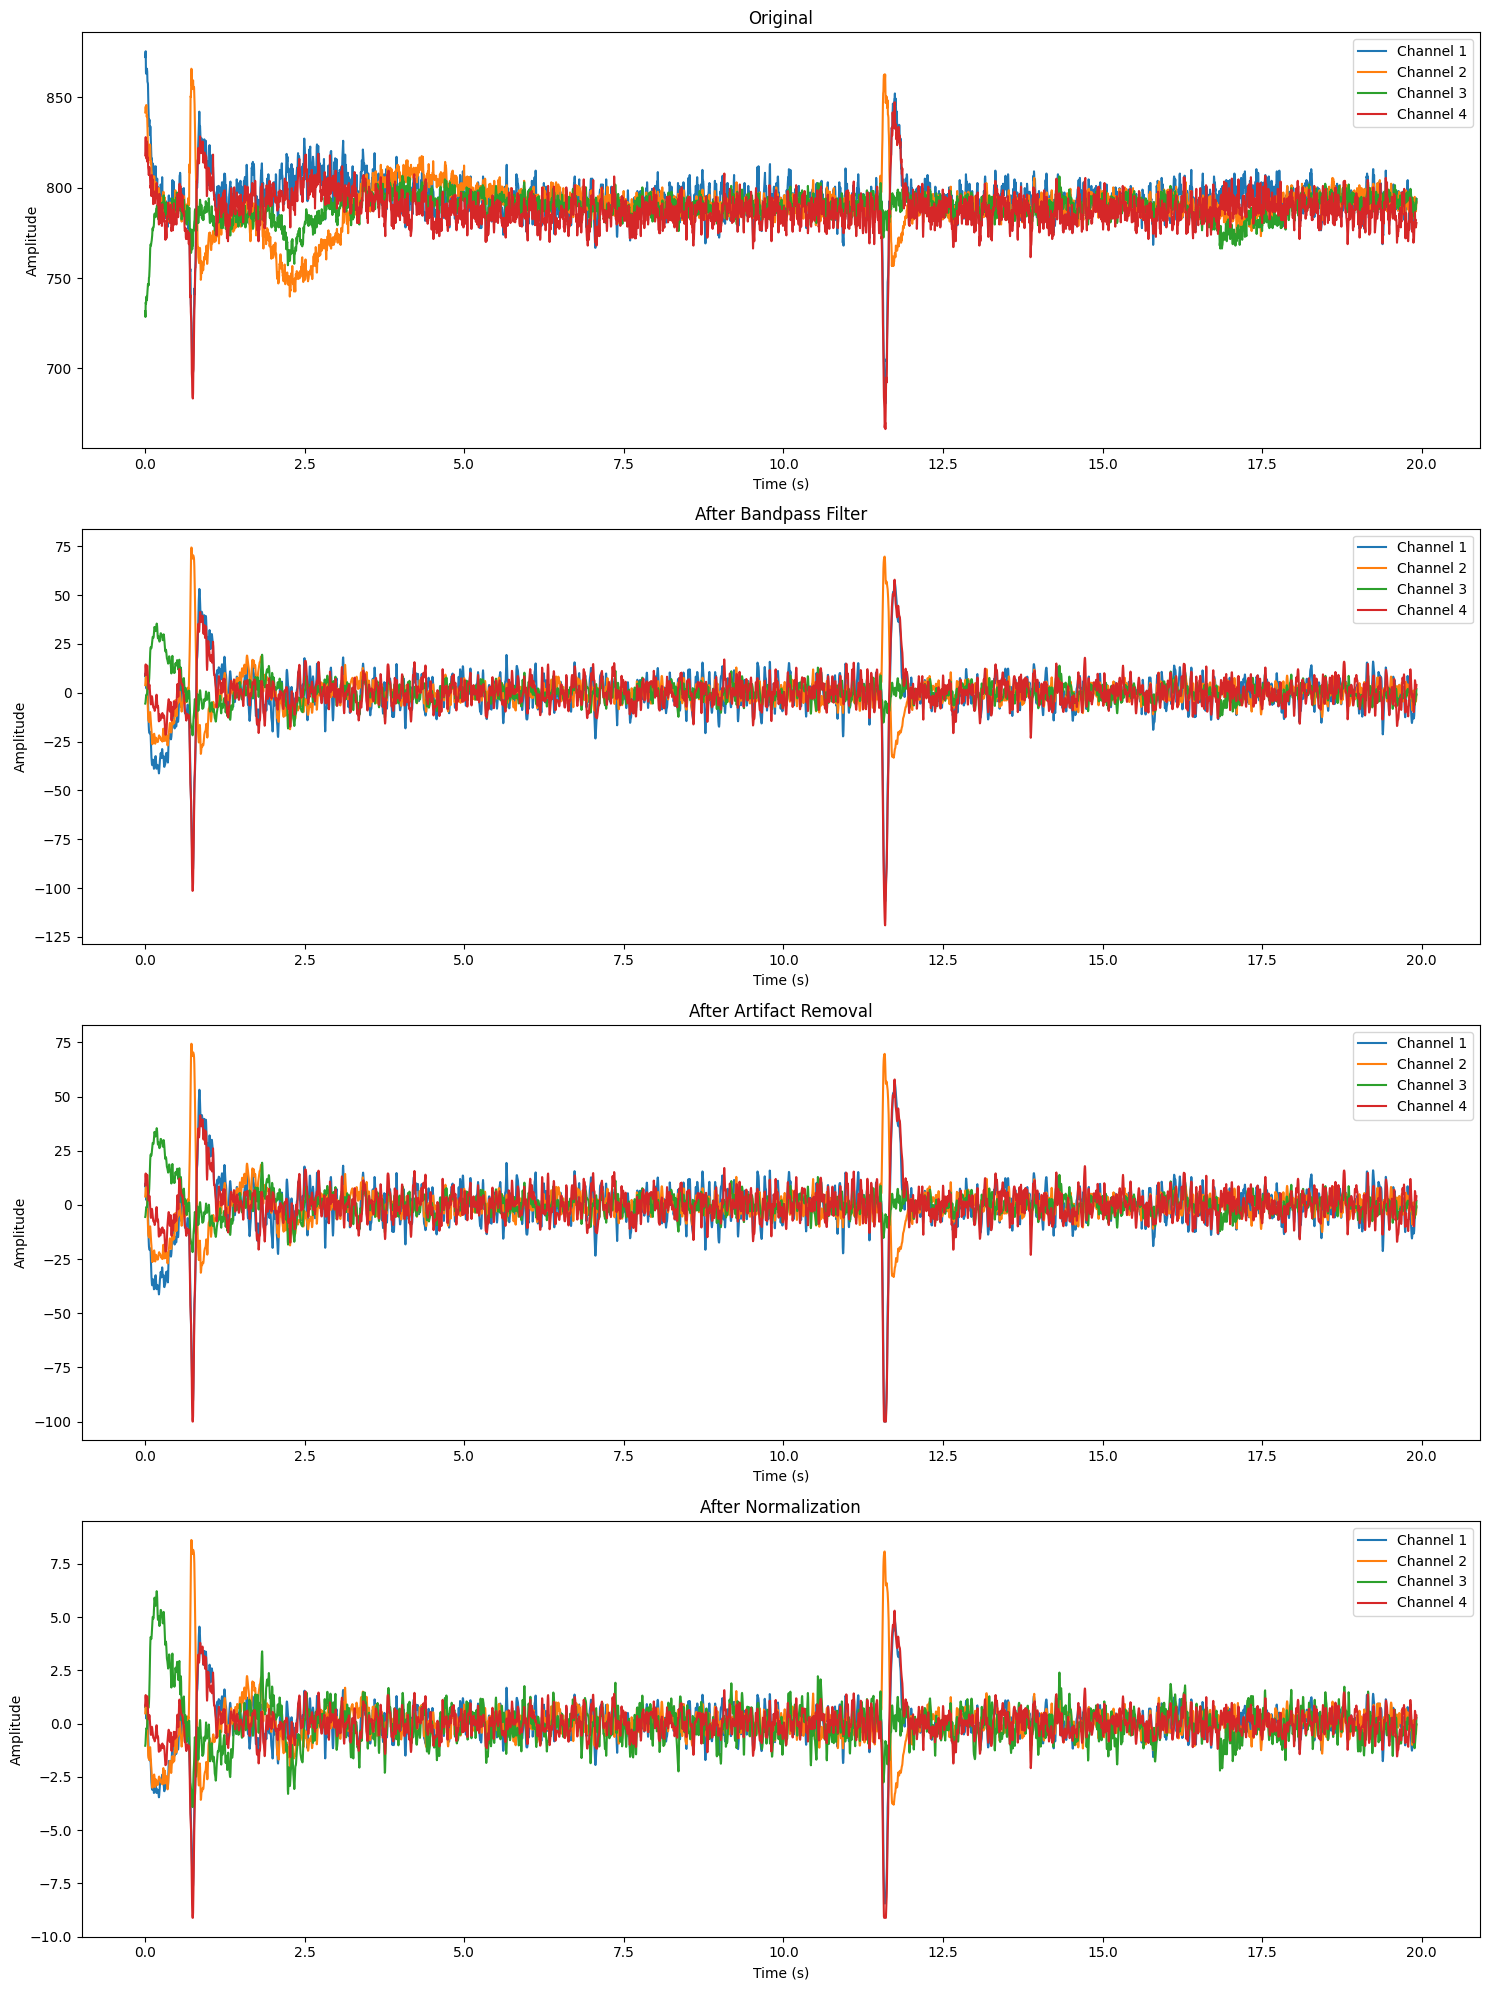

Original Data Statistics:
                 0            1            2            3
count  5100.000000  5100.000000  5100.000000  5100.000000
mean    794.218646   790.143992   788.895698   787.909862
std      12.562614    12.697957     7.152635    12.097925
min     680.549438   739.780212   728.498169   666.446899
25%     788.534790   786.520142   785.311340   782.490845
50%     793.772888   790.952393   789.743591   787.728943
75%     799.413940   795.384644   793.369934   793.369934
max     875.567749   865.897461   808.278381   847.362610

Processed Data Statistics:
                  0             1             2            3
count  5.100000e+03  5.100000e+03  5.100000e+03  5100.000000
mean  -2.786442e-18  5.572884e-18 -8.916615e-17     0.000000
std    1.000098e+00  1.000098e+00  1.000098e+00     1.000098
min   -8.440045e+00 -3.807981e+00 -3.918048e+00    -9.120436
25%   -3.507687e-01 -3.441572e-01 -5.272780e-01    -0.387148
50%    4.759570e-02  5.724741e-03 -4.051566e-02     0.0077

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler

class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
    
    def preprocess_file(self, file_path):
        """Complete preprocessing pipeline for a single file"""
        # Load data
        data = pd.read_csv(file_path, header=None)
        # Convert data to float, replacing any non-numeric values with NaN
        channel_data = data.iloc[:, 1:5].apply(pd.to_numeric, errors='coerce').values
        
        # Remove any rows with NaN values
        channel_data = channel_data[~np.isnan(channel_data).any(axis=1)]
        
        # Store original data for comparison
        original_data = channel_data.copy()
        
        # Apply bandpass filter
        filtered_data = self.apply_bandpass_filter(channel_data)
        
        # Remove artifacts (simplified example - you may need more sophisticated methods)
        cleaned_data = self.remove_artifacts(filtered_data)
        
        # Normalize
        normalized_data = self.scaler.fit_transform(cleaned_data)
        
        # Visualize the preprocessing steps
        self.visualize_preprocessing(original_data, filtered_data, cleaned_data, normalized_data)
        
        # Output some statistics
        self.output_statistics(original_data, normalized_data)
        
        return normalized_data
    
    def apply_bandpass_filter(self, data):
        """Apply bandpass filter to remove artifacts"""
        nyquist = self.config.SAMPLING_RATE / 2
        low = 0.5 / nyquist
        high = 45 / nyquist
        b, a = signal.butter(4, [low, high], btype='band')
        return signal.filtfilt(b, a, data, axis=0)
    
    def remove_artifacts(self, data):
        """Simple artifact removal (replace with more sophisticated method if needed)"""
        # This is a very simple method - you might want to use ICA or other advanced techniques
        return np.clip(data, -100, 100)  # Clip extreme values
    
    def visualize_preprocessing(self, original, filtered, cleaned, normalized):
        """Visualize the data at each preprocessing step"""
        fig, axs = plt.subplots(4, 1, figsize=(15, 20))
        times = np.arange(len(original)) / self.config.SAMPLING_RATE
        
        titles = ['Original', 'After Bandpass Filter', 'After Artifact Removal', 'After Normalization']
        datas = [original, filtered, cleaned, normalized]
        
        for i, (title, data) in enumerate(zip(titles, datas)):
            for j in range(4):
                axs[i].plot(times, data[:, j], label=f'Channel {j+1}')
            axs[i].set_title(title)
            axs[i].set_xlabel('Time (s)')
            axs[i].set_ylabel('Amplitude')
            axs[i].legend()
        
        plt.tight_layout()
        plt.show()
    
    def output_statistics(self, original, processed):
        """Output some basic statistics for comparison"""
        print("Original Data Statistics:")
        print(pd.DataFrame(original).describe())
        print("\nProcessed Data Statistics:")
        print(pd.DataFrame(processed).describe())

# Assuming you have defined the Config class
class Config:
    SAMPLING_RATE = 256  # Hz, adjust this to match your data

# Usage example
config = Config()
processor = DataProcessor(config)
processed_data = processor.preprocess_file('/workspaces/EEG_to_Speech/Dataset/Train/Left.2023-01-29 19_36_09.340519.csv')